## Introduction

In this notebook, I am going to fine-tune the LayoutLM model by Microsoft Research on the [FUNSD] dataset, which is a collection of annotated form documents. The goal of our model is to learn the annotations of a number of labels ("question", "answer", "header" and "other") on those forms, such that it can be used to annotate unseen forms in the future.



## 1 .Install libraries

Install the `unilm` package, and then the `transformers` package (which updates the outdated `transformers` package that is included in the `unilm` package). The reason we also install the `unilm` package is because we need its preprocessing files.

In [ ]:
! rm -r unilm
! git clone -b remove_torch_save https://github.com/NielsRogge/unilm.git
! cd unilm/layoutlm
! pip install unilm/layoutlm

rm: cannot remove 'unilm': No such file or directory
Cloning into 'unilm'...
remote: Enumerating objects: 1329, done.
remote: Counting objects: 100% (464/464), done.
remote: Compressing objects: 100% (325/325), done.
remote: Total 1329 (delta 209), reused 312 (delta 114), pack-reused 865
Receiving objects: 100% (1329/1329), 706.47 KiB | 3.30 MiB/s, done.
Resolving deltas: 100% (689/689), done.
Processing ./unilm/layoutlm
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 635 kB 5.3 MB/s 
     |████████████████████████████████| 195 kB 47.0 MB/s 
     |████████████████████████████████| 5.5 MB 22.6 MB/s 
     |

In [ ]:
! rm -r transformers
! git clone https://github.com/huggingface/transformers.git
! cd transformers
! pip install ./transformers

rm: cannot remove 'transformers': No such file or directory
Cloning into 'transformers'...
remote: Enumerating objects: 83615, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 83615 (delta 4), reused 11 (delta 4), pack-reused 83604
Receiving objects: 100% (83615/83615), 66.73 MiB | 24.18 MiB/s, done.
Resolving deltas: 100% (60049/60049), done.
Processing ./transformers
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 50

## 2 .Getting and exploring the data

Here we download the data of the [FUNSD dataset](https://guillaumejaume.github.io/FUNSD/) from the web. This results in a directory called "data" being created, which has 2 subdirectories, one for training and one for testing. Each of those has 2 subdirectories in turn, one containing the images as png files and one containing the annotations in json format.

In [ ]:
! wget https://guillaumejaume.github.io/FUNSD/dataset.zip
! unzip dataset.zip && mv dataset data && rm -rf dataset.zip __MACOSX

--2021-09-07 02:07:31--  https://guillaumejaume.github.io/FUNSD/dataset.zip
Resolving guillaumejaume.github.io (guillaumejaume.github.io)... 185.199.108.153, 185.199.110.153, 185.199.111.153, ...
Connecting to guillaumejaume.github.io (guillaumejaume.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16838830 (16M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  16.06M  --.-KB/s    in 0.1s    

2021-09-07 02:07:31 (116 MB/s) - ‘dataset.zip’ saved [16838830/16838830]

Archive:  dataset.zip
   creating: dataset/
   creating: dataset/training_data/
  inflating: dataset/training_data/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/dataset/
   creating: __MACOSX/dataset/training_data/
  inflating: __MACOSX/dataset/training_data/._.DS_Store  
   creating: dataset/training_data/images/
  inflating: dataset/training_data/images/92091873.png  
   creating: __MACOSX/dataset/training_data/images

Let's take a look at a training example. For this, we are going to use PIL (Python Image Library).

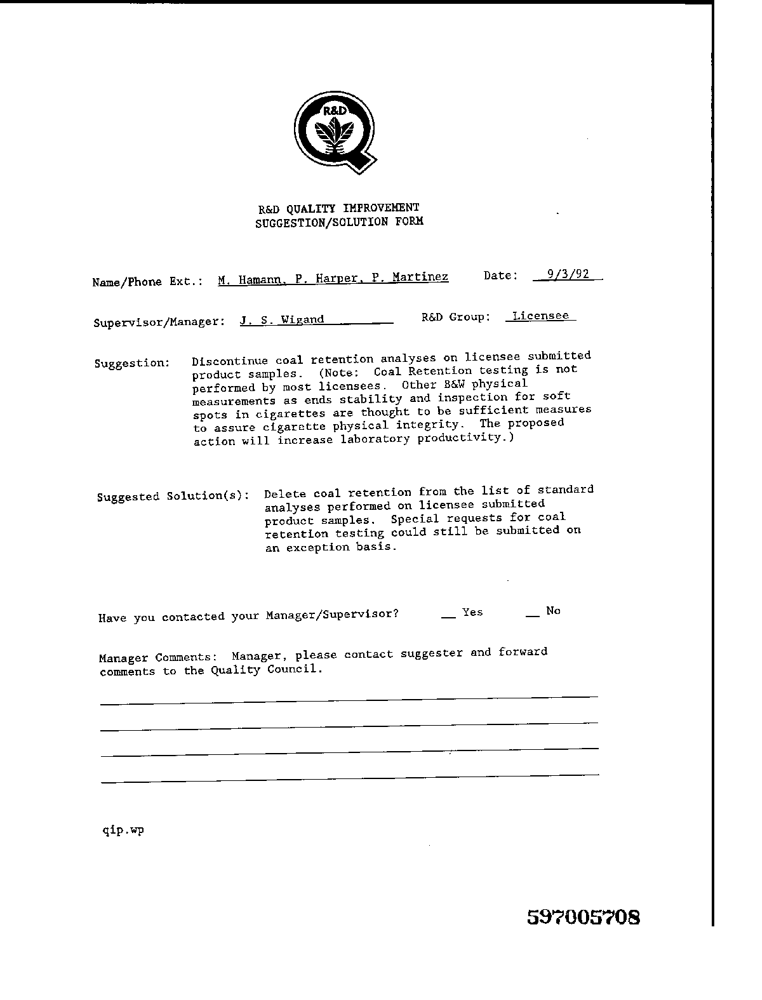

In [ ]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("/content/data/training_data/images/0000971160.png")
image = image.convert("RGB")
image

Now let's plot its corresponding annotations. Basically, if you type `data['form']`, you get a list of all general annotations. Each general annotation has a label, a bounding box, and one or more words, which in also have their own bounding box. The bounding boxes are in [xleft, ytop, xright, ybottom] format.
 

In [ ]:
import json

with open('/content/data/training_data/annotations/0000971160.json') as f:
  data = json.load(f)

for annotation in data['form']:
  print(annotation)

{'box': [292, 91, 376, 175], 'text': 'R&D', 'label': 'other', 'words': [{'box': [292, 91, 376, 175], 'text': 'R&D'}], 'linking': [], 'id': 0}
{'box': [219, 316, 225, 327], 'text': ':', 'label': 'question', 'words': [{'box': [219, 316, 225, 327], 'text': ':'}], 'linking': [], 'id': 1}
{'box': [95, 355, 169, 370], 'text': 'Suggestion:', 'label': 'question', 'words': [{'box': [95, 355, 169, 370], 'text': 'Suggestion:'}], 'linking': [[2, 16]], 'id': 2}
{'box': [482, 268, 518, 282], 'text': 'Date:', 'label': 'question', 'words': [{'box': [482, 268, 518, 282], 'text': 'Date:'}], 'linking': [[3, 12]], 'id': 3}
{'box': [511, 309, 570, 323], 'text': 'Licensee', 'label': 'answer', 'words': [{'box': [511, 309, 570, 323], 'text': 'Licensee'}], 'linking': [[13, 4]], 'id': 4}
{'box': [211, 651, 217, 662], 'text': '', 'label': 'question', 'words': [{'box': [211, 651, 217, 662], 'text': ''}], 'linking': [], 'id': 5}
{'box': [461, 605, 483, 619], 'text': 'Yes', 'label': 'question', 'words': [{'box': [4

The PIL library has a handy ImageDraw module,it allows to draw things (such as rectangles) on an image:

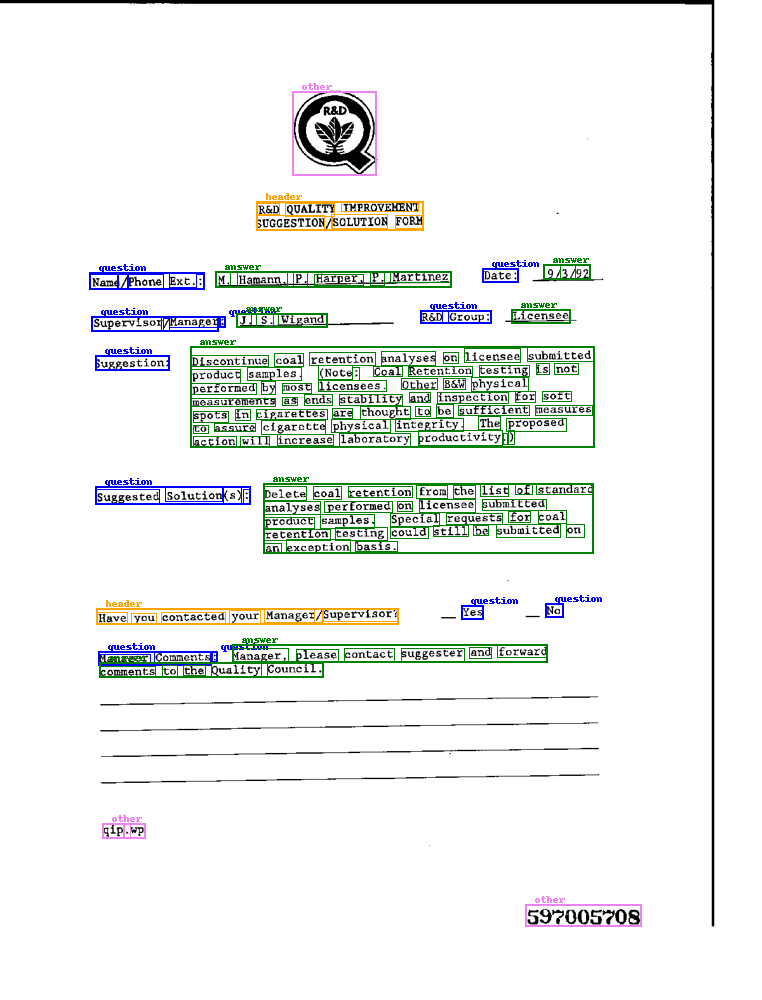

In [ ]:
draw = ImageDraw.Draw(image, "RGBA")

font = ImageFont.load_default()

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for annotation in data['form']:
  label = annotation['label']
  general_box = annotation['box']
  draw.rectangle(general_box, outline=label2color[label], width=2)
  draw.text((general_box[0] + 10, general_box[1] - 10), label, fill=label2color[label], font=font)
  words = annotation['words']
  for word in words:
    box = word['box']
    draw.rectangle(box, outline=label2color[label], width=1)

image

## 3 .Preprocessing the training and test data, create labels 

Next, we need to turn the document images into individual tokens and corresponding labels (BIOES format, see further). We do this both for the training and test datasets. Make sure to run this from the `/content` directory:

In [ ]:
! python unilm/layoutlm/examples/seq_labeling/preprocess.py --data_dir data/training_data/annotations \
                                                      --data_split train \
                                                      --output_dir data \
                                                      --model_name_or_path microsoft/layoutlm-base-uncased \
                                                      --max_len 510

! python unilm/layoutlm/examples/seq_labeling/preprocess.py --data_dir data/testing_data/annotations \
                                                      --data_split test \
                                                      --output_dir data \
                                                      --model_name_or_path microsoft/layoutlm-base-uncased \
                                                      --max_len 510

Downloading: 100% 170/170 [00:00<00:00, 161kB/s]
Downloading: 100% 606/606 [00:00<00:00, 495kB/s]
Downloading: 100% 232k/232k [00:00<00:00, 2.79MB/s]
Downloading: 100% 466k/466k [00:00<00:00, 3.17MB/s]
Downloading: 100% 112/112 [00:00<00:00, 94.4kB/s]


Next, we create a labels.txt file that contains the unique labels of the FUNSD dataset:

In [ ]:
! cat data/train.txt | cut -d$'\t' -f 2 | grep -v "^$"| sort | uniq > data/labels.txt

## 4 .Define the training and test PyTorch datasets using LayoutLMTokenizer

First, we create a list containing the unique labels based on `data/labels.txt` (run this from the content directory):

In [ ]:
from torch.nn import CrossEntropyLoss

def get_labels(path):
    with open(path, "r") as f:
        labels = f.read().splitlines()
    if "O" not in labels:
        labels = ["O"] + labels
    return labels

labels = get_labels("data/labels.txt")
num_labels = len(labels)
label_map = {i: label for i, label in enumerate(labels)}
# Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
pad_token_label_id = CrossEntropyLoss().ignore_index

We can see that the dataset uses the so-called BIOES annotation scheme to annotate the tokens. This means that a given token can be either at the beginning (B), inside (I), outside (O), at the end (E) or start (S) of a given entity. Entities include ANSWER, QUESTION, HEADER and OTHER: 

In [ ]:
print(labels)

['B-ANSWER', 'B-HEADER', 'B-QUESTION', 'E-ANSWER', 'E-HEADER', 'E-QUESTION', 'I-ANSWER', 'I-HEADER', 'I-QUESTION', 'O', 'S-ANSWER', 'S-HEADER', 'S-QUESTION']


Next, we can create a PyTorch dataset and corresponding dataloader (both for training and evaluation). We specify the tokenizer to use (layoutlm-base-uncased ),  

In [ ]:
from transformers import LayoutLMTokenizer
from layoutlm.data.funsd import FunsdDataset, InputFeatures
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

args = {'local_rank': -1,
        'overwrite_cache': True,
        'data_dir': '/content/data',
        'model_name_or_path':'microsoft/layoutlm-base-uncased',
        'max_seq_length': 512,
        'model_type': 'layoutlm',}

# class to turn the keys of a dict into attributes (thanks Stackoverflow)
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDict(args)

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

# the LayoutLM authors already defined a specific FunsdDataset, so we are going to use this here
train_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="train")
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset,
                              sampler=train_sampler,
                              batch_size=2)

eval_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="test")
eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(eval_dataset,
                             sampler=eval_sampler,
                            batch_size=2)

In [ ]:
len(train_dataloader)

75

In [ ]:
len(eval_dataloader)

26

In [ ]:
batch = next(iter(train_dataloader))
input_ids = batch[0][0]
tokenizer.decode(input_ids)

'[CLS] 970220 to : from : date : mailfile description quantity : maildate : program # : seeds suppression notes 1 2 3 4 7 6 8 9 10 5 5 25 273 700418 3, 984 system rjr mailfile table update sheet alert number rjr ir - suz / art drew huyett 3 / 7 / 97 102 - eclipse program group corp / multibrand mailfile id : mail order - indy responders dataset name ( complete by ir ) 3 / 17 / 97 brc codes w81 carton order form t codes na mailfile cells hd home delivery sp sneak preview this is for notes 51673 4300 970220 xls mailfile [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

## 5 .Define and fine-tune the model using LayoutLMForTokenClassification

As this is a sequence labeling task, we are going to load `LayoutLMForTokenClassification` (the base sized model) from the hub. We are going to fine-tune it on a downstream task, namely FUNSD.

In [ ]:
from transformers import LayoutLMForTokenClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(torch.__version__)

1.9.0+cu102


In [ ]:
from transformers import LayoutLMForTokenClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=num_labels)
model.to(device)

Downloading:   0%|          | 0.00/453M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

LayoutLMForTokenClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0): LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
         

## 6 .Training using AdamW optimizer , learning rate 5e-5 , cross entropy loss function , 5 epochs. Save model.

A deep learning neural network learns to map a set of inputs to a set of outputs from training data.

We cannot calculate the perfect weights for a neural network; there are too many unknowns. Instead, the problem of learning is cast as a search or optimization problem and an algorithm is used to navigate the space of possible sets of weights the model may use in order to make good or good enough predictions.

GPU required 

Output: trained model

Data fed to network

Network makes a prediction 

Errors in prediction used to update the strength of the connections between neurons 

Through the training process, the connections are further adjusted util the network is making predictions with sufficient accuracy 

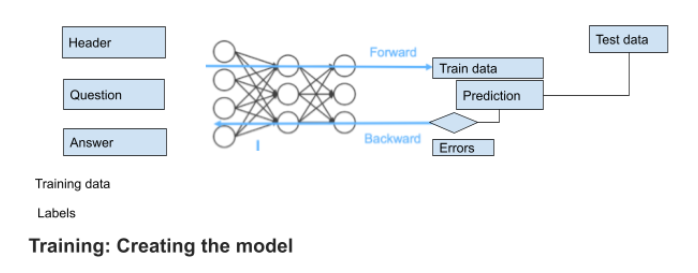


Having chosen an optimization algorithm, the function used to evaluate a candidate solution (i.e. a set of weights) is referred to as the objective function.

We may seek to maximize or minimize the objective function, meaning that we are searching for a candidate solution that has the highest or lowest score respectively.

Typically, with neural networks, we seek to minimize the error. As such, the objective function is often referred to as a cost function or a loss function and the value calculated by the loss function is referred to as simply “loss.”

Cross entropy is used , as this is a multi class classification problem.


In [ ]:
from transformers import AdamW
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 5
t_total = len(train_dataloader) * num_train_epochs # total number of training steps 

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
  for batch in tqdm(train_dataloader, desc="Training"):
      input_ids = batch[0].to(device)
      bbox = batch[4].to(device)
      attention_mask = batch[1].to(device)
      token_type_ids = batch[2].to(device)
      labels = batch[3].to(device)

      # forward pass
      outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                      labels=labels)
      loss = outputs.loss

      # print loss every 100 steps
      if global_step % 100 == 0:
        print(f"Loss after {global_step} steps: {loss.item()}")

      # backward pass to get the gradients 
      loss.backward()

      #print("Gradients on classification head:")
      #print(model.classifier.weight.grad[6,:].sum())

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1

Training:   0%|          | 0/75 [00:00<?, ?it/s]

Loss after 0 steps: 2.5399227142333984


Training:  33%|███▎      | 25/75 [00:10<00:21,  2.33it/s]

Loss after 100 steps: 0.9811919331550598


Training:  67%|██████▋   | 50/75 [00:21<00:10,  2.30it/s]

Loss after 200 steps: 0.5614479184150696


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Loss after 300 steps: 0.767366349697113


Training: 100%|██████████| 75/75 [00:32<00:00,  2.31it/s]


The parameters for PyTorch networks are stored in a model's state_dict. We can see the state dict contains the weight and bias matrices for each of our layers.

In [ ]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 LayoutLMForTokenClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0): LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=T

Save the state dict with torch.save to a file 'checkpoint.pth'.


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/layoutlm/checkpoint.pth')
from google.colab import files
# download checkpoint file
files.download('/content/drive/MyDrive/layoutlm/checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The state_dict can be loaded with torch.load


In [ ]:
from transformers import LayoutLMForTokenClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from transformers import LayoutLMForTokenClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=num_labels)
model.to(device)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

LayoutLMForTokenClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0): LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
state_dict = torch.load('/content/drive/MyDrive/layoutlm/checkpoint.pth')
print(state_dict.keys())
#run this only if on CPU ( when colab GPU is not avilable )
#device = torch.device("cpu")
#to run the model on CPU, In the model_loader.py file, add, map_location={'cuda:0': 'cpu'} whereever, torch.load() function is called.
model.load_state_dict(state_dict)# GPU 
#my_model = model.load_state_dict(torch.load(state_dict, map_location=torch.device('cpu')))

odict_keys(['layoutlm.embeddings.position_ids', 'layoutlm.embeddings.word_embeddings.weight', 'layoutlm.embeddings.position_embeddings.weight', 'layoutlm.embeddings.x_position_embeddings.weight', 'layoutlm.embeddings.y_position_embeddings.weight', 'layoutlm.embeddings.h_position_embeddings.weight', 'layoutlm.embeddings.w_position_embeddings.weight', 'layoutlm.embeddings.token_type_embeddings.weight', 'layoutlm.embeddings.LayerNorm.weight', 'layoutlm.embeddings.LayerNorm.bias', 'layoutlm.encoder.layer.0.attention.self.query.weight', 'layoutlm.encoder.layer.0.attention.self.query.bias', 'layoutlm.encoder.layer.0.attention.self.key.weight', 'layoutlm.encoder.layer.0.attention.self.key.bias', 'layoutlm.encoder.layer.0.attention.self.value.weight', 'layoutlm.encoder.layer.0.attention.self.value.bias', 'layoutlm.encoder.layer.0.attention.output.dense.weight', 'layoutlm.encoder.layer.0.attention.output.dense.bias', 'layoutlm.encoder.layer.0.attention.output.LayerNorm.weight', 'layoutlm.encode

<All keys matched successfully>

## 7 .Evaluation on test set 

Now let's evaluate on the test set
Once the model is fit, it can be evaluated on the test dataset.
This can be achieved by using the DataLoader for the test dataset and collecting the predictions for the test set, then comparing the predictions to the expected values of the test set and calculating a performance metric.

In [ ]:
import numpy as np
from tqdm import tqdm
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)

eval_loss = 0.0
nb_eval_steps = 0
preds = None
out_label_ids = None

# put model in evaluation mode
model.eval()
for batch in tqdm(eval_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch[0].to(device)
        bbox = batch[4].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                        labels=labels)
        # get the loss and logits
        tmp_eval_loss = outputs.loss
        logits = outputs.logits

        eval_loss += tmp_eval_loss.item()
        nb_eval_steps += 1

        # compute the predictions
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = labels.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, labels.detach().cpu().numpy(), axis=0
            )

# compute average evaluation loss
eval_loss = eval_loss / nb_eval_steps
preds = np.argmax(preds, axis=2)

out_label_list = [[] for _ in range(out_label_ids.shape[0])]
preds_list = [[] for _ in range(out_label_ids.shape[0])]

for i in range(out_label_ids.shape[0]):
    for j in range(out_label_ids.shape[1]):
        if out_label_ids[i, j] != pad_token_label_id:
            out_label_list[i].append(label_map[out_label_ids[i][j]])
            preds_list[i].append(label_map[preds[i][j]])

results = {
    "loss": eval_loss,
    "precision": precision_score(out_label_list, preds_list),
    "recall": recall_score(out_label_list, preds_list),
    "f1": f1_score(out_label_list, preds_list),
}
print(results)

Evaluating: 100%|██████████| 26/26 [00:03<00:00,  7.09it/s]


{'loss': 2.5495315056580763, 'precision': 0.022237545250818825, 'recall': 0.06453226613306653, 'f1': 0.03307692307692308}


## 8 . Prepare for Inference







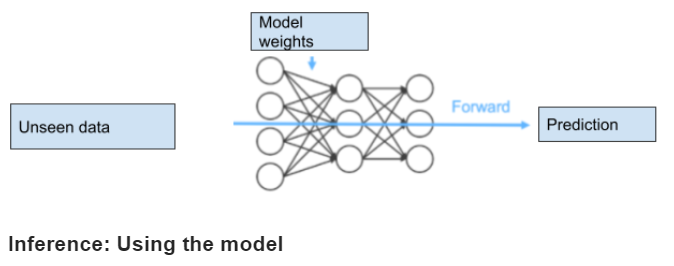


A model fit on training data nad tested on test data can be used to make a prediction on new data.

This requires that the data be wrapped in a PyTorch Tensor data structure.

The prediction too will be a Tensor, although you can retrieve the NumPy array by detaching the Tensor from the automatic differentiation graph and calling the NumPy function.



In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 40 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (3,469 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
!chmod 755 '/content/drive/MyDrive/layoutlm/layoutlm_preprocess.py'

In [ ]:
! echo $PYTHONPATH

/env/python


In [ ]:
!pwd 

/content


In [ ]:
! export PYTHONPATH=$PYTHONPATH:pwd:pwd/content/drive/MyDrive/layoutlm/

In [ ]:
import sys
sys.path.insert(1, '/content/drive/MyDrive/layoutlm/')
from layoutlm_preprocess import *


In [ ]:
image_path='/content/drive/MyDrive/layoutlm/testimage.PNG'
image, words, boxes, actual_boxes = preprocess(image_path)

In [ ]:
#run preprocess script  
model_path='/content/drive/MyDrive/layoutlm/checkpoint.pth'
model=model_load(model_path,num_labels)
word_level_predictions, final_boxes=convert_to_features(image, words, boxes, actual_boxes, model)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

[7, 1, 7, 9, 7, 7, 4, 7, 9, 2, 8, 12, 12, 5, 12, 9, 9, 10, 9, 9, 2, 8, 8, 8, 8, 8, 8, 5, 4, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

## 9 .Trying it out on sample Minute Book data 

We split the unseen data into smaller images ( corresponding to smaller use cases )

Use the fine-tuned model and test it on unseen data, and record results

LayoutLM relies on an external OCR engine for now. The test data itself also contains the annotated bounding boxes, but let's run an OCR engine ourselves.

Load in a image of the test set, run OCR on it to get the bounding boxes, then run LayoutLM on the individual tokens and visualize the result.


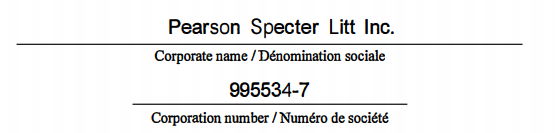

In [ ]:
image = Image.open("/content/drive/MyDrive/layoutlm/testimage.PNG")
image = image.convert("RGB")
image

In [ ]:
details = pytesseract.image_to_data(image)

To perform OCR on an image, its important to preprocess the image using CV. 

In [ ]:
image_path="/content/drive/MyDrive/layoutlm/testimage.PNG"
#importing opencv
import cv2

img = cv2.imread(image_path)
#Resize the image
img = cv2.resize(img, None, fx=0.5, fy=0.5)
#Convert image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#Convert image to black and white
adaptive_threshold = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 85, 11)

image, words, boxes, actual_boxes = preprocess(image_path)

In [ ]:
print(boxes)

[[304, 142, 432, 255], [452, 135, 574, 285], [594, 142, 641, 255], [657, 142, 709, 255], [277, 375, 383, 481], [387, 398, 434, 458], [434, 375, 614, 458], [621, 375, 693, 458], [414, 616, 558, 729], [272, 842, 400, 947], [403, 842, 484, 924], [490, 842, 499, 924], [502, 842, 590, 924], [596, 842, 621, 924], [627, 842, 700, 924]]


In [ ]:
print(words)

['Pearson', 'Specter', 'Litt', 'Inc.', '‘Corporate', 'name', '/Dénomination', 'sociale', '995534-7', 'Corporation', 'number', '/', 'Numéro', 'de', 'société']


In [ ]:
model_path='/content/drive/MyDrive/layoutlm/checkpoint.pth'
model=model_load(model_path,num_labels)
word_level_predictions, final_boxes=convert_to_features(image, words, boxes, actual_boxes, model)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

[7, 1, 7, 9, 7, 7, 4, 7, 9, 2, 8, 12, 12, 5, 12, 9, 9, 10, 9, 9, 2, 8, 8, 8, 8, 8, 8, 5, 4, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [ ]:
print(word_level_predictions)

[1, 7, 7, 4, 7, 9, 2, 8, 12, 12, 5, 9, 9, 9, 2, 8, 8, 8, 8, 5]


In [ ]:
label_map

{0: 'B-ANSWER',
 1: 'B-HEADER',
 2: 'B-QUESTION',
 3: 'E-ANSWER',
 4: 'E-HEADER',
 5: 'E-QUESTION',
 6: 'I-ANSWER',
 7: 'I-HEADER',
 8: 'I-QUESTION',
 9: 'O',
 10: 'S-ANSWER',
 11: 'S-HEADER',
 12: 'S-QUESTION'}

In [ ]:
print(final_boxes)

[[169, 19, 240, 34], [251, 18, 319, 38], [330, 19, 356, 34], [365, 19, 394, 34], [365, 19, 394, 34], [154, 50, 213, 64], [154, 50, 213, 64], [215, 53, 241, 61], [241, 50, 341, 61], [241, 50, 341, 61], [345, 50, 385, 61], [230, 82, 310, 97], [230, 82, 310, 97], [230, 82, 310, 97], [151, 112, 222, 126], [224, 112, 269, 123], [272, 112, 277, 123], [279, 112, 328, 123], [331, 112, 345, 123], [348, 112, 389, 123]]


Visualize the result

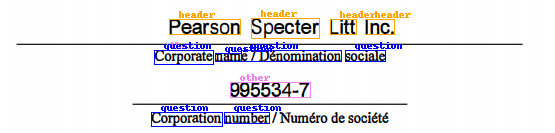

In [ ]:
draw = ImageDraw.Draw(image)
import pandas as pd
df_out =pd.DataFrame()
font = ImageFont.load_default()

def iob_to_label(label):
  if label != 'O':
    return label[2:]
  else:
    return "other"

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}
ocr_df = pytesseract.image_to_data(image, lang = 'eng', output_type='data.frame') 
#for prediction, box in zip(word_level_predictions, final_boxes):
for prediction, box, ind in zip(word_level_predictions, final_boxes, ocr_df.index):  
    predicted_label = iob_to_label(label_map[prediction]).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)
    #print(words[ind],label_map[prediction])
    #print(words[ind],predicted_label)
    #save to dataframe
    df_out.at[ind, 'words'] = words[ind]
    df_out.at[ind, 'label'] = predicted_label 
image

In [ ]:
df_out

,words,label
0,Pearson,header
1,Specter,header
2,Litt,header
3,Inc.,header
4,‘Corporate,header
5,name,other
6,/Dénomination,question
7,sociale,question
8,995534-7,question
9,Corporation,question


In [ ]:
df_out.to_csv('/content/drive/MyDrive/layoutlm/out_file.tsv', sep = '\t')

Save to tsv 



Inference on new document 1 

This model keeps spatial information 

Hence the first line was predicted as a header





Compare this to the ground truth annotation developed using a free trial of an online annotator.
Online annotators are available that can provide annotations in the desired format for downstream tasks.  

In [ ]:
import json

with open('/content/drive/MyDrive/layoutlm/testimage.json') as f:
  data = json.load(f)

for annotation in data['form']:
  print(annotation)

{'box': [167, 18, 396, 36], 'text': 'Pearson Specter Litt Inc.', 'label': 'ACOM', 'words': [{'box': [167, 18, 243, 37], 'text': 'Pearson'}, {'box': [250, 17, 321, 40], 'text': 'Specter'}, {'box': [329, 18, 358, 36], 'text': 'Litt'}, {'box': [364, 18, 396, 36], 'text': 'Inc.'}], 'linking': [], 'id': 0}
{'box': [154, 49, 250, 63], 'text': 'Corporate name', 'label': 'QCOM', 'words': [{'box': [154, 49, 215, 66], 'text': 'Corporate'}, {'box': [215, 52, 250, 63], 'text': 'name'}], 'linking': [], 'id': 1}
{'box': [229, 81, 312, 99], 'text': '995534-7', 'label': 'ANUM', 'words': [{'box': [229, 81, 312, 99], 'text': '995534-7'}], 'linking': [], 'id': 2}
{'box': [150, 111, 333, 126], 'text': 'Corporation number/Numéro /', 'label': 'QNUM', 'words': [{'box': [150, 111, 223, 128], 'text': 'Corporation'}, {'box': [224, 111, 333, 126], 'text': 'number/Numéro /'}], 'linking': [], 'id': 3}


Note that we only print the labels for the general bounding boxes, for readability. Each general bounding box consists of one or more bounding boxes, which comprise the individual words:

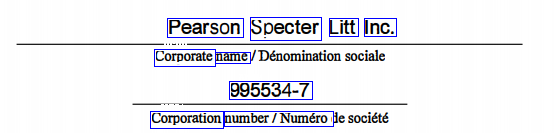

In [ ]:
image = Image.open("/content/drive/MyDrive/layoutlm/testimage.PNG")
image = image.convert('RGB')

draw = ImageDraw.Draw(image)

#label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for annotation in data['form']:
  label = annotation['label']
  general_box = annotation['box']
  draw.rectangle(general_box, width=2)
  #draw.rectangle(general_box, outline=label2color[label], width=2)
  #draw.text((general_box[0] + 10, general_box[1] - 10), label, fill=label2color[label], font=font)
  draw.text((general_box[0] + 10, general_box[1] - 10), label, font=font)
  words = annotation['words']
  for word in words:
    box = word['box']
    #draw.rectangle(box, outline=label2color[label], width=1)
    draw.rectangle(box, outline = 'blue', width=1)
image

Inference on a document from the minute book converted to an image.


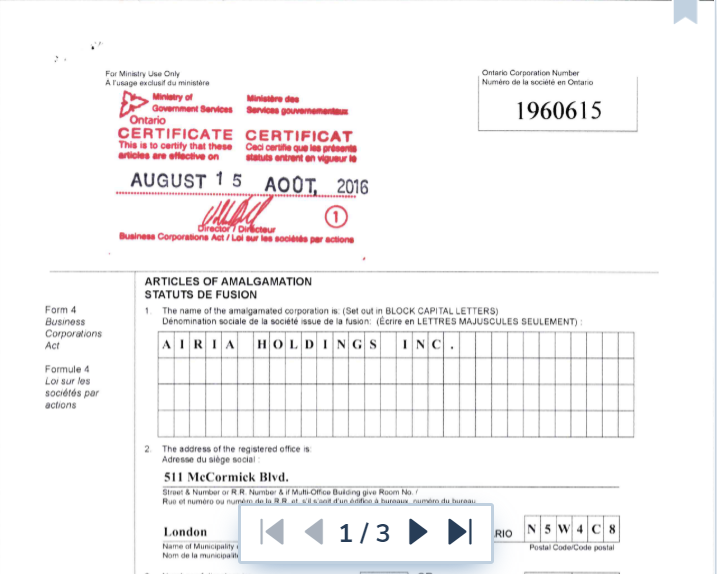

In [ ]:
#image = Image.open('/content/form_example.jpg')
image = Image.open("/content/drive/MyDrive/layoutlm/pdf1_amend_image.PNG")
image = image.convert("RGB")
image


In [ ]:
details = pytesseract.image_to_data(image)

In [ ]:
image_path="/content/drive/MyDrive/layoutlm/pdf1_amend_image.PNG"
#importing opencv
import cv2

In [ ]:
img = cv2.imread(image_path)
#Resize the image
img = cv2.resize(img, None, fx=0.5, fy=0.5)
#Convert image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#Convert image to black and white
adaptive_threshold = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 85, 11)

In [ ]:
image, words, boxes, actual_boxes = preprocess(image_path)

In [ ]:
print(boxes)

[[147, 123, 203, 135], [206, 123, 225, 134], [228, 123, 251, 135], [341, 226, 492, 247], [179, 472, 269, 498], [269, 482, 304, 498], [308, 482, 435, 498], [202, 505, 269, 520], [276, 505, 295, 520], [301, 505, 358, 520], [672, 120, 707, 130], [711, 120, 767, 134], [769, 121, 807, 132], [722, 175, 838, 209], [62, 533, 93, 547], [99, 533, 105, 545], [203, 534, 206, 547], [227, 534, 246, 547], [251, 538, 280, 547], [284, 534, 315, 547], [319, 534, 393, 550], [397, 536, 458, 548], [463, 534, 499, 550], [503, 536, 532, 548], [538, 534, 578, 548], [582, 534, 631, 548], [635, 534, 694, 550], [227, 552, 301, 566], [305, 554, 343, 566], [347, 554, 359, 566], [365, 552, 415, 566], [419, 555, 447, 566], [451, 554, 464, 566], [468, 554, 478, 566], [482, 554, 514, 566], [525, 550, 546, 567], [564, 555, 577, 566], [582, 554, 635, 566], [640, 554, 722, 566], [728, 554, 804, 569], [186, 590, 281, 608], [297, 590, 326, 608], [359, 590, 524, 608], [562, 590, 615, 608], [228, 747, 375, 763], [400, 759, 4

In [ ]:
print(words)

['Ferny', 'vs', 'O04', 'CERTIFICAT', 'ARTICLES', 'OF', 'AMALGAMATION,', 'STATUTS', 'DE', 'FUSION', '‘ont', 'Corpuraton', 'eta', '1960615', 'Form', '4', '1', 'The', 'name', 'ofthe', 'amalgamated', 'corporation', '(Se', 'tn', 'BLOCK', 'CAPITAL', 'LETTERS)', 'Denomination', 'sodae', 'ge', 'sche', 'nave', 'de', 'la', 'Mion', '(Een', 'fon', 'LETTRES', 'MAJUSCULES', 'SEULEMENT)', 'arr', 'TA', 'HOLDINGS', 'INC', 'places', 'oll', 'Ls', '2.', 'The', 'adres', 'ofthe', 'reiered', 'ofee', '‘arouse', 'a', 'alige', 'wot!', 'SIL', 'MeCormick', 'Blvd.', 'cs']


In [ ]:

model_path='/content/drive/MyDrive/layoutlm/checkpoint.pth'
model=model_load(model_path,num_labels)
word_level_predictions, final_boxes=convert_to_features(image, words, boxes, actual_boxes, model)


Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 7, 7, 4, 2, 8, 8, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 9, 7, 7, 4, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 6, 9, 6, 9, 6, 9, 9, 9, 7, 9, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 

In [ ]:
print(word_level_predictions)

[9, 9, 9, 9, 1, 7, 7, 4, 2, 8, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 7, 7, 4, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 7, 9]


In [ ]:
label_map

{0: 'B-ANSWER',
 1: 'B-HEADER',
 2: 'B-QUESTION',
 3: 'E-ANSWER',
 4: 'E-HEADER',
 5: 'E-QUESTION',
 6: 'I-ANSWER',
 7: 'I-HEADER',
 8: 'I-QUESTION',
 9: 'O',
 10: 'S-ANSWER',
 11: 'S-HEADER',
 12: 'S-QUESTION'}

In [ ]:
print(final_boxes)

[[106, 71, 146, 78], [148, 71, 162, 77], [164, 71, 180, 78], [245, 130, 353, 142], [129, 271, 193, 286], [193, 277, 218, 286], [221, 277, 312, 286], [221, 277, 312, 286], [145, 290, 193, 299], [198, 290, 212, 299], [216, 290, 257, 299], [482, 69, 507, 75], [482, 69, 507, 75], [510, 69, 550, 77], [552, 70, 579, 76], [518, 101, 601, 120], [45, 306, 67, 314], [71, 306, 76, 313], [146, 307, 148, 314], [163, 307, 177, 314], [180, 309, 201, 314], [204, 307, 226, 314], [229, 307, 282, 316], [285, 308, 329, 315], [332, 307, 358, 316], [332, 307, 358, 316], [361, 308, 382, 315], [386, 307, 415, 315], [418, 307, 453, 315], [456, 307, 498, 316], [456, 307, 498, 316], [163, 317, 216, 325], [219, 318, 246, 325], [249, 318, 258, 325], [262, 317, 298, 325], [301, 319, 321, 325], [324, 318, 333, 325], [336, 318, 343, 325], [346, 318, 369, 325], [377, 316, 392, 326], [377, 316, 392, 326], [405, 319, 414, 325], [418, 318, 456, 325], [459, 318, 518, 325], [522, 318, 577, 327], [522, 318, 577, 327], [134,

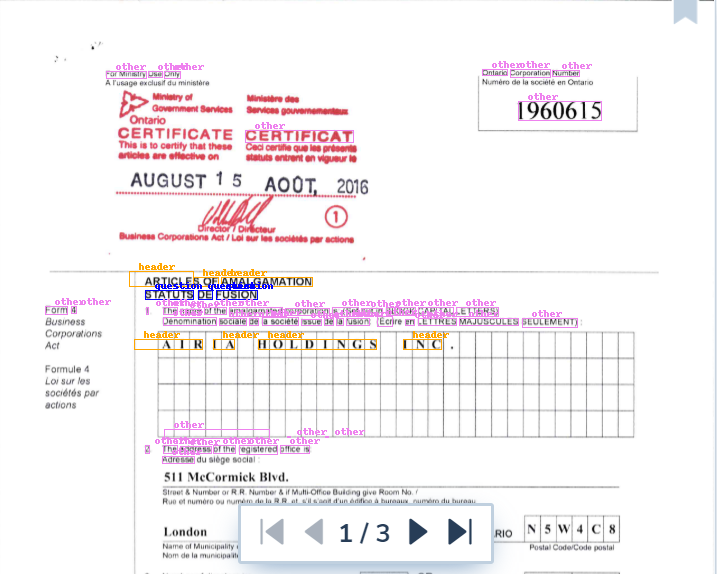

In [ ]:
draw = ImageDraw.Draw(image)
import pandas as pd
df_out =pd.DataFrame()
font = ImageFont.load_default()

def iob_to_label(label):
  if label != 'O':
    return label[2:]
  else:
    return "other"

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}
ocr_df = pytesseract.image_to_data(image, lang = 'eng', output_type='data.frame') 
#for prediction, box in zip(word_level_predictions, final_boxes):
for prediction, box, ind, w in zip(word_level_predictions, final_boxes, ocr_df.index, words):  
    predicted_label = iob_to_label(label_map[prediction]).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)
    #print(words[ind],label_map[prediction])
    #print(words[ind],predicted_label)
    #save to dataframe
    df_out.at[ind, 'words'] = w
    df_out.at[ind, 'label'] = predicted_label 
image

In [ ]:
df_out

,words,label
0,Ferny,other
1,vs,other
2,O04,other
3,CERTIFICAT,other
4,ARTICLES,header
...,...,...
56,wot!,other
57,SIL,other
58,MeCormick,other
59,Blvd.,other


In [ ]:
df_out.to_csv('/content/drive/MyDrive/layoutlm/out_file_amend_page.tsv', sep = '\t')

This is the first run. Parameters used are learning rate 5e-5, cross entropy loss function, 5 epochs, AdamW optimizer.
Augmenting the images in addition to changing the parameters and hyperparameters, using our own annotated minute books in place of the FUNSD dataset, developing an annotation strategy ( labels , NLP task ) are some experiments that can be conducted to come up with the desired output.


 